In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import shutil

In [ ]:
for file in os.listdir(data_dir):
    if file.endswith(".jpg"):
        img_path = os.path.join(data_dir, file)
        txt_path = os.path.join(data_dir, file.replace(".jpg", ".txt"))

        if os.path.exists(txt_path):
            shutil.copy(img_path, os.path.join(labeled_dir, file))
            shutil.copy(txt_path, os.path.join(labeled_dir, os.path.basename(txt_path)))

In [ ]:
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
import random

# label_dir = Path(labeled_dir)
# classes_file = label_dir / "classes.txt"


In [ ]:
classes = classes_file.read_text().splitlines()
print("Classes:")
for i, c in enumerate(classes):
    print(i, c)


Classes:
0 good rice
1 defective rice
2 foreign object


In [ ]:
instance_counter = Counter()
image_counter = defaultdict(set)  # class_id → set(images)

total_images = 0

for txt in label_dir.glob("*.txt"):
    total_images += 1
    lines = txt.read_text().strip().splitlines()

    for line in lines:
        parts = line.split()
        if len(parts) != 5:
            continue
        cls = int(parts[0])
        instance_counter[cls] += 1
        image_counter[cls].add(txt.stem)


In [ ]:
rows = []

for cls_id, cls_name in enumerate(classes):
    rows.append({
        "class_id": cls_id,
        "class_name": cls_name,
        "instances": instance_counter[cls_id],
        "images_with_class": len(image_counter[cls_id]),
        "avg_instances_per_image": (
            instance_counter[cls_id] / max(1, len(image_counter[cls_id]))
        )
    })

df = pd.DataFrame(rows)
df


,class_id,class_name,instances,images_with_class,avg_instances_per_image
0,0,good rice,840,108,7.777778
1,1,defective rice,1660,108,15.370370
2,2,foreign object,619,108,5.731481


In [ ]:
df["instance_ratio_vs_max"] = df["instances"] / df["instances"].max()
df.sort_values("instances", ascending=False)


,class_id,class_name,instances,images_with_class,avg_instances_per_image,instance_ratio_vs_max
1,1,defective rice,1660,108,15.370370,1.000000
0,0,good rice,840,108,7.777778,0.506024
2,2,foreign object,619,108,5.731481,0.372892


In [ ]:
print(f"Total images: {total_images}")
print(f"Total labeled objects: {sum(instance_counter.values())}")

print("\n⚠️ Classes with <10% of max instances:")
display(df[df["instance_ratio_vs_max"] < 0.1])


Total images: 109
Total labeled objects: 3119

⚠️ Classes with <10% of max instances:


,class_id,class_name,instances,images_with_class,avg_instances_per_image,instance_ratio_vs_max


In [ ]:
# Single source folder
# source_dir = Path(data_dir)

# Output dataset root
dataset_root = Path("/content/drive/MyDrive/yolo_dataset")

train_ratio = 0.8
seed = 42


In [ ]:
for split in ["train", "val"]:
    (dataset_root / "images" / split).mkdir(parents=True, exist_ok=True)
    (dataset_root / "labels" / split).mkdir(parents=True, exist_ok=True)


In [ ]:
pairs = []

image_exts = [".jpg", ".jpeg", ".png"]

for file in source_dir.iterdir():
    if file.suffix.lower() in image_exts:
        label = source_dir / f"{file.stem}.txt"
        if label.exists():
            pairs.append((file, label))

print(f"Total valid pairs found: {len(pairs)}")


Total valid pairs found: 108


In [ ]:
random.seed(seed)
random.shuffle(pairs)

split_idx = int(len(pairs) * train_ratio)

train_pairs = pairs[:split_idx]
val_pairs = pairs[split_idx:]

print(f"Train images: {len(train_pairs)}")
print(f"Val images  : {len(val_pairs)}")


Train images: 86
Val images  : 22


In [ ]:
def copy_pairs(pairs, split):
    for img, label in pairs:
        shutil.copy(img, dataset_root / "images" / split / img.name)
        shutil.copy(label, dataset_root / "labels" / split / label.name)

copy_pairs(train_pairs, "train")
copy_pairs(val_pairs, "val")


In [ ]:
assert len(list((dataset_root / "images/train").glob("*"))) == len(train_pairs)
assert len(list((dataset_root / "labels/train").glob("*"))) == len(train_pairs)

assert len(list((dataset_root / "images/val").glob("*"))) == len(val_pairs)
assert len(list((dataset_root / "labels/val").glob("*"))) == len(val_pairs)

print("✅ Dataset split looks correct")


✅ Dataset split looks correct


In [10]:
classes = [
    "good rice",
    "defective rice",
    "foreign object"
]

In [11]:
import cv2
import random
import matplotlib.pyplot as plt


In [12]:
def draw_yolo_boxes(img_path, label_path, classes):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w, _ = img.shape

    if not label_path.exists():
        return img

    with open(label_path) as f:
        lines = f.readlines()

    for line in lines:
        cls, xc, yc, bw, bh = map(float, line.strip().split())
        cls = int(cls)

        x1 = int((xc - bw / 2) * w)
        y1 = int((yc - bh / 2) * h)
        x2 = int((xc + bw / 2) * w)
        y2 = int((yc + bh / 2) * h)

        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(
            img,
            classes[cls],
            (x1, y1 - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 0, 0),
            1
        )

    return img


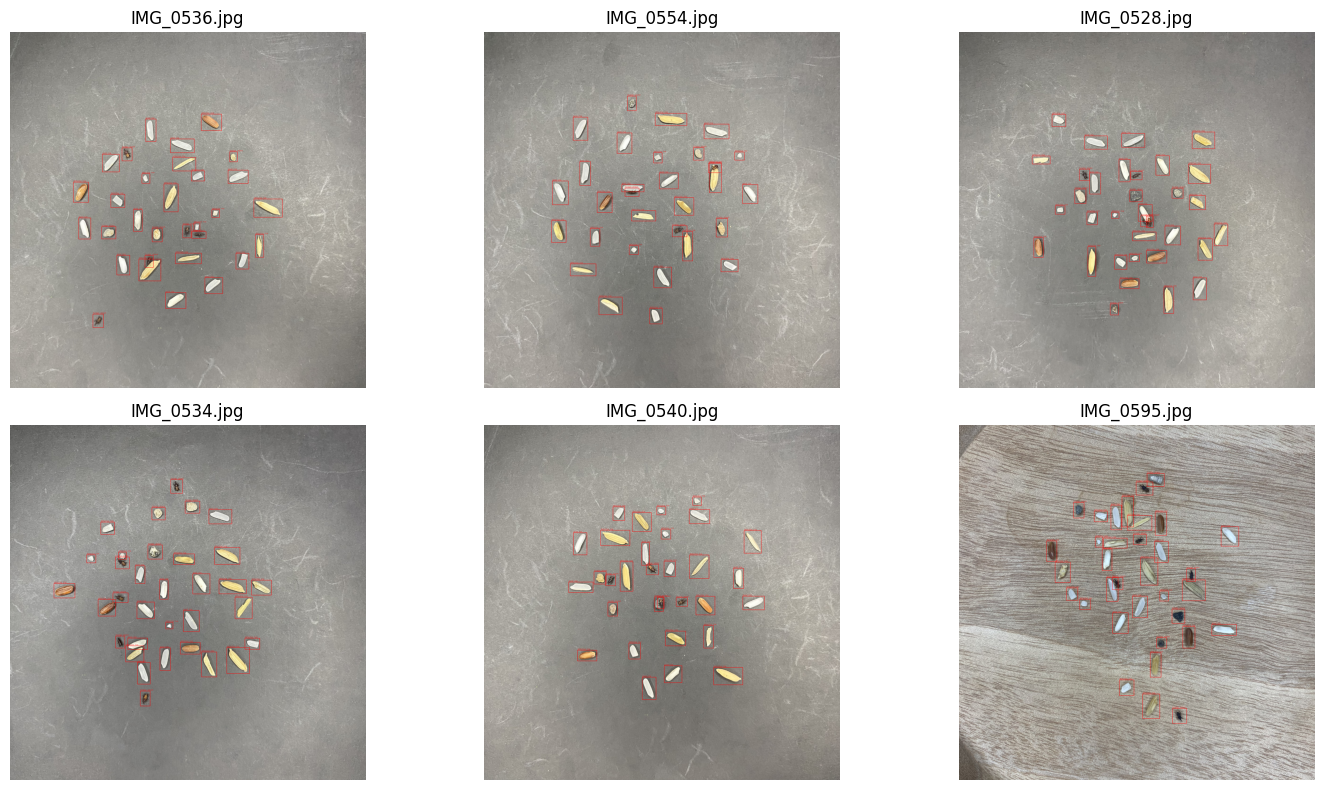

In [13]:
from pathlib import Path

dataset_root = Path("/content/drive/MyDrive/yolo_dataset")

split = "train"  # change to "val" if needed

image_dir = dataset_root / "images" / split
label_dir = dataset_root / "labels" / split

samples = random.sample(list(image_dir.glob("*.jpg")), 6)

plt.figure(figsize=(15, 8))

for i, img_path in enumerate(samples):
    label_path = label_dir / f"{img_path.stem}.txt"
    img = draw_yolo_boxes(img_path, label_path, classes)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_path.name)

plt.tight_layout()
plt.show()


In [14]:
from collections import Counter


In [15]:
def count_classes(label_dir):
    counter = Counter()

    for label_file in label_dir.glob("*.txt"):
        with open(label_file) as f:
            for line in f:
                cls = int(line.strip().split()[0])
                counter[cls] += 1

    return counter


In [16]:
train_counts = count_classes(dataset_root / "labels" / "train")
val_counts = count_classes(dataset_root / "labels" / "val")


In [17]:
print("TRAIN distribution")
for i, name in enumerate(classes):
    print(f"{name:15s}: {train_counts[i]}")


TRAIN distribution
good rice      : 672
defective rice : 1336
foreign object : 492


In [18]:
print("\nVAL distribution")
for i, name in enumerate(classes):
    print(f"{name:15s}: {val_counts[i]}")



VAL distribution
good rice      : 168
defective rice : 324
foreign object : 127


In [19]:
import numpy as np


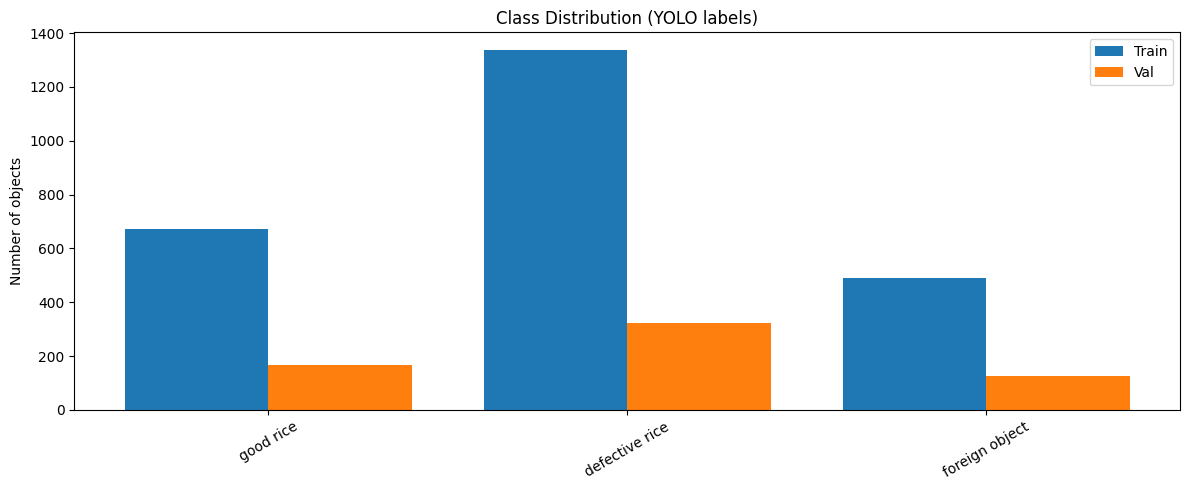

In [20]:
x = np.arange(len(classes))
train_vals = [train_counts[i] for i in range(len(classes))]
val_vals = [val_counts[i] for i in range(len(classes))]

plt.figure(figsize=(12, 5))
plt.bar(x - 0.2, train_vals, 0.4, label="Train")
plt.bar(x + 0.2, val_vals, 0.4, label="Val")

plt.xticks(x, classes, rotation=30)
plt.ylabel("Number of objects")
plt.title("Class Distribution (YOLO labels)")
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.4 MB/s eta 0:00:00


In [22]:
from ultralytics import YOLO
import os


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [23]:
DATA_YAML = dataset_root / "data.yaml"

with open(DATA_YAML, "r") as f:
    print(f.read())


path: /content/drive/MyDrive/yolo_dataset
train: images/train
val: images/val

nc: 3
names: ['good rice', 'defective rice', 'foreign object']


In [24]:
model = YOLO("yolo11n.pt")

In [25]:
results = model.train(
    data=DATA_YAML,
    imgsz=1024,        # IMPORTANT for tiny objects
    epochs=200,
    batch=8,
    optimizer="AdamW",
    device=0,
    lr0=1e-3,
    warmup_epochs=5,

    # Augmentation tuned for small objects
    mosaic=0.2,
    mixup=0.0,
    copy_paste=0.0,
    scale=0.3,
    translate=0.05,
    degrees=0.0,
    shear=0.0,
    fliplr=0.5,

    hsv_h=0.01,
    hsv_s=0.4,
    hsv_v=0.4,

    close_mosaic=10,
    patience=50,
    workers=4,
)


Ultralytics 8.3.242 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01, hsv_s=0.4, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=0.2, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=50, perspective=0.0, plo

In [26]:
results = model.predict(
    source="/content/drive/MyDrive/yolo_dataset/images/val",
    imgsz=1024,
    conf=0.15,
    max_det=300,
    save=True
)



image 1/22 /content/drive/MyDrive/yolo_dataset/images/val/IMG_0494.jpg: 1024x1024 8 good rices, 19 defective rices, 4 foreign objects, 10.1ms
image 2/22 /content/drive/MyDrive/yolo_dataset/images/val/IMG_0497.jpg: 1024x1024 9 good rices, 19 defective rices, 4 foreign objects, 9.8ms
image 3/22 /content/drive/MyDrive/yolo_dataset/images/val/IMG_0505.jpg: 1024x1024 10 good rices, 21 defective rices, 5 foreign objects, 9.8ms
image 4/22 /content/drive/MyDrive/yolo_dataset/images/val/IMG_0509.jpg: 1024x1024 8 good rices, 15 defective rices, 5 foreign objects, 9.8ms
image 5/22 /content/drive/MyDrive/yolo_dataset/images/val/IMG_0511.jpg: 1024x1024 10 good rices, 21 defective rices, 8 foreign objects, 9.8ms
image 6/22 /content/drive/MyDrive/yolo_dataset/images/val/IMG_0515.jpg: 1024x1024 10 good rices, 19 defective rices, 11 foreign objects, 9.8ms
image 7/22 /content/drive/MyDrive/yolo_dataset/images/val/IMG_0516.jpg: 1024x1024 7 good rices, 19 defective rices, 5 foreign objects, 9.8ms
image 8

In [28]:
metrics = model.val(
    data=DATA_YAML,
    imgsz=1024,
    batch=8,
    device=0
)

print("mAP@0.5:", metrics.box.map50)
print("mAP@0.5:0.95:", metrics.box.map)

Ultralytics 8.3.242 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 344.8±22.8 MB/s, size: 2737.8 KB)
val: Scanning /content/drive/MyDrive/yolo_dataset/labels/val.cache... 22 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 22/22 23.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 1.7s/it 5.1s
                   all         22        619      0.934      0.959       0.98      0.719
             good rice         22        168      0.931      0.976      0.982      0.762
        defective rice         22        324      0.943      0.926      0.977      0.734
        foreign object         22        127      0.926      0.976       0.98      0.662
Speed: 20.8ms preprocess, 63.5ms inference, 0.0ms loss, 6.8ms postprocess per image
Results saved to /content/runs/detect/val2
mAP@0.5: 0.9796926104622946
mAP@0.5:0.95: 0.7194315314959934


In [35]:
results = model.predict(
    source="/content/drive/MyDrive/yolo_dataset/images/val",
    imgsz=1024,
    batch=1,
    device=0,
)

import time
times = []

for r in results:
    times.append(r.speed["inference"])

print("Avg inference time (ms):", sum(times)/len(times))



image 1/22 /content/drive/MyDrive/yolo_dataset/images/val/IMG_0494.jpg: 1024x1024 8 good rices, 17 defective rices, 4 foreign objects, 17.0ms
image 2/22 /content/drive/MyDrive/yolo_dataset/images/val/IMG_0497.jpg: 1024x1024 9 good rices, 19 defective rices, 4 foreign objects, 42.9ms
image 3/22 /content/drive/MyDrive/yolo_dataset/images/val/IMG_0505.jpg: 1024x1024 8 good rices, 21 defective rices, 5 foreign objects, 14.5ms
image 4/22 /content/drive/MyDrive/yolo_dataset/images/val/IMG_0509.jpg: 1024x1024 8 good rices, 15 defective rices, 5 foreign objects, 14.5ms
image 5/22 /content/drive/MyDrive/yolo_dataset/images/val/IMG_0511.jpg: 1024x1024 9 good rices, 21 defective rices, 7 foreign objects, 14.4ms
image 6/22 /content/drive/MyDrive/yolo_dataset/images/val/IMG_0515.jpg: 1024x1024 9 good rices, 18 defective rices, 11 foreign objects, 14.4ms
image 7/22 /content/drive/MyDrive/yolo_dataset/images/val/IMG_0516.jpg: 1024x1024 7 good rices, 19 defective rices, 5 foreign objects, 14.9ms
imag

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 1., 1., 1., 1., 0., 0., 0., 1., 2., 0., 2., 1., 1., 1., 1., 1., 0., 1., 1., 2., 1., 0., 1., 0., 1., 1., 1., 2.], device='cuda:0')
conf: tensor([0.9790, 0.9756, 0.9705, 0.9668, 0.9564, 0.9533, 0.9507, 0.9213, 0.9195, 0.9181, 0.9158, 0.9144, 0.9114, 0.9103, 0.9075, 0.8980, 0.8970, 0.8928, 0.8855, 0.8849, 0.8827, 0.8789, 0.8680, 0.8639, 0.8615, 0.8608, 0.8385, 0.8286, 0.8266], device='cuda:0')
data: tensor([[1.8808e+03, 1.4963e+03, 2.0965e+03, 1.5804e+03, 9.7902e-01, 0.0000e+00],
        [1.8392e+03, 2.0230e+03, 2.0036e+03, 2.3034e+03, 9.7557e-01, 1.0000e+00],
        [1.4934e+03, 1.7879e+03, 1.6107e+03, 1.9711e+03, 9.7045e-01, 1.0000e+00],
        [1.5412e+03, 2.0594e+03, 1.6542e+03, 2.2665e+03, 9.6678e-01, 1.0000e+00],
        [6.8297e+02, 1.6770e+03, 8.9021e+02, 1.9591e+03, 9.5636e-01, 1.0000e+00],
        [2.3478e+03, 1.8142e+03, 2.5766e+03, 1.9286e+03, 9.5335e-01, 0.0000e+00],
        [1.1380e+03, 1.4663e+03, 

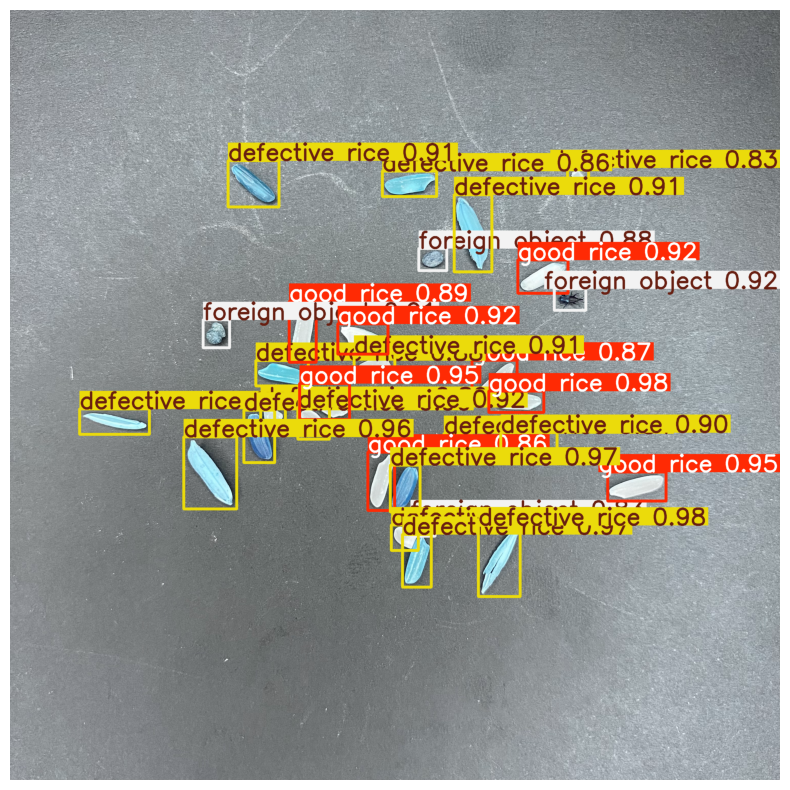

good rice (0.98) -> [     1880.8      1496.3      2096.5      1580.4]
defective rice (0.98) -> [     1839.2        2023      2003.6      2303.4]
defective rice (0.97) -> [     1493.4      1787.9      1610.7      1971.1]
defective rice (0.97) -> [     1541.2      2059.4      1654.2      2266.5]
defective rice (0.96) -> [     682.97        1677      890.21      1959.1]
good rice (0.95) -> [     2347.8      1814.2      2576.6      1928.6]
good rice (0.95) -> [       1138      1466.3      1333.9      1608.2]
good rice (0.92) -> [     1287.5      1232.8      1484.5      1351.8]
defective rice (0.92) -> [     1130.7      1560.2        1254      1685.4]
foreign object (0.92) -> [     2137.8      1094.7      2261.4      1179.5]
good rice (0.92) -> [     1994.6      981.02      2191.2      1112.6]
foreign object (0.91) -> [     758.81      1216.1      862.49      1326.6]
defective rice (0.91) -> [     1744.3      725.52      1892.5      1028.2]
defective rice (0.91) -> [       1352      1348.9 

In [38]:
result = results[0]  # still can index the batch
print(result.boxes)  # Boxes object

# Plotting
plt.figure(figsize=(10,10))
plt.imshow(result.plot())  # returns an RGB image with boxes
plt.axis('off')
plt.show()

# Access boxes programmatically
for box in result.boxes:
    cls_id = int(box.cls[0])
    label = model.names[cls_id]
    conf = float(box.conf[0])
    xyxy = box.xyxy[0].cpu().numpy()  # [x1, y1, x2, y2]
    print(f"{label} ({conf:.2f}) -> {xyxy}")

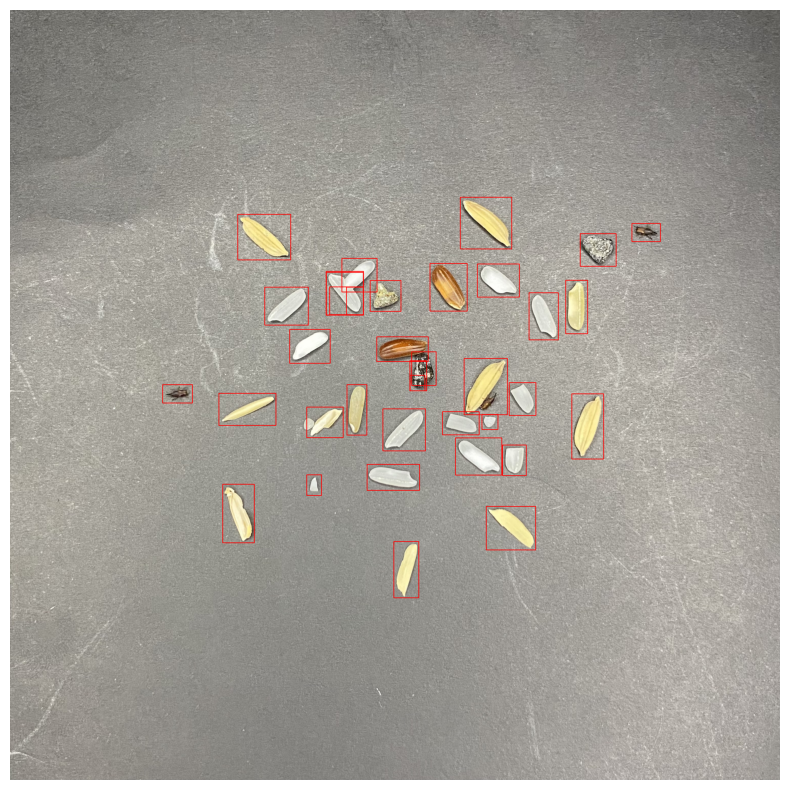

In [39]:
img_path = '/content/drive/MyDrive/yolo_dataset/images/val/IMG_0511.jpg'

# Predict
results = model.predict(img_path, conf=0.25, verbose=False)
result = results[0]

# Load original image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Draw boxes only
for box in result.boxes.xyxy.cpu().numpy():  # xyxy coordinates
    x1, y1, x2, y2 = box.astype(int)
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # blue boxes

# Display
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [40]:
model.export(
    format="tflite",
    imgsz=640,
    int8=True,
    data="/content/drive/MyDrive/yolo_dataset/data.yaml"
)


Ultralytics 8.3.242 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (5.3 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'ai-edge-litert>=1.2.0', 'onnx>=1.12.0,<2.0.0', 'onnx2tf>=1.26.3', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 20 packages in 2.08s
Prepared 11 packages in 10.34s
Installed 11 packages in 395ms
 + ai-edge-litert==2.1.0
 + backports-strenum==1.3.1
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.20.0
 + onnx-graphsurgeon==0.5.8
 + onnx2tf==1.28.8
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.80
 + sng4onnx==1.0.4

requiremen

/usr/local/lib/python3.12/dist-packages/torch/onnx/_internal/torchscript_exporter/utils.py:1447: OnnxExporterWarning: Exporting to ONNX opset version 22 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 20. To use a newer opset version, consider 'torch.onnx.export(..., dynamo=True)'. 
  warnings.warn(


ONNX: slimming with onnxslim 0.1.80...
ONNX: export success ✅ 1.7s, saved as '/content/runs/detect/train/weights/best.onnx' (10.2 MB)
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.npy...: 100% ━━━━━━━━━━━━ 1/1 42.3files/s 0.0s
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.28.8...
Saved artifact at '/content/runs/detect/train/weights/best_saved_model'. The following endpoints are available:

* Endpoint 'serving_default'
  inputs_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 640, 640, 3), dtype=tf.float32, name='images')
Output Type:
  TensorSpec(shape=(1, 7, 8400), dtype=tf.float32, name=None)
Captures:
  134674991394896: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  134674991393744: TensorSpec(shape=(3, 3, 3, 16), dtype=tf.float32, name=None)
  134674991395664: TensorSpec(shape=(16,), dtype=tf.float32, name=None)
  134674989042384: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)

'/content/runs/detect/train/weights/best_saved_model/best_int8.tflite'

In [45]:
!yolo export model="/content/runs/detect/train/weights/best.pt" format=tflite data="/content/drive/MyDrive/yolo_dataset/data.yaml" int8=True nms=False

Ultralytics 8.3.242 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 1024, 1024) BCHW and output shape(s) (1, 7, 21504) (5.3 MB)
E0000 00:00:1767054581.265133   17362 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767054581.270148   17362 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767054581.282691   17362 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767054581.282715   17362 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the sam

In [47]:
import tensorflow as tf
import numpy as np
import cv2
import time

interpreter = tf.lite.Interpreter(model_path="/content/runs/detect/train/weights/best_saved_model/best_int8.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]["shape"]  # (1, H, W, 3)
imgsz = input_shape[1]



In [48]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (imgsz, imgsz))

    img = np.expand_dims(img, axis=0)

    if input_details[0]["dtype"] == np.uint8:
        img = img.astype(np.uint8)
    else:
        img = img.astype(np.float32) / 255.0

    return img


In [49]:
def yolo_tflite_infer(image):
    interpreter.set_tensor(input_details[0]["index"], image)

    start = time.perf_counter()
    interpreter.invoke()
    latency_ms = (time.perf_counter() - start) * 1000

    outputs = [
        interpreter.get_tensor(out["index"])
        for out in output_details
    ]

    return outputs, latency_ms


In [50]:
image = preprocess_image("test.jpg")

latencies = []
for _ in range(50):
    _, latency = yolo_tflite_infer(image)
    latencies.append(latency)

print(f"Avg latency: {np.mean(latencies):.2f} ms")


error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [2]:
import os
import time
import cv2
import numpy as np
import tensorflow as tf

# =========================
# CONFIG
# =========================
MODEL_PATH = "/content/runs/detect/train/weights/best_saved_model/best_int8.tflite"
IMAGE_DIR = "/content/drive/MyDrive/yolo_dataset/images/val"          # validation images
LABEL_DIR = "/content/drive/MyDrive/yolo_dataset/labels/val"          # YOLO txt labels
IMG_SIZE = 1024
CONF_THRES = 0.25
IOU_THRES = 0.5
MAX_IMAGES = 100

# =========================
# LOAD MODEL
# =========================
interpreter = tf.lite.Interpreter(model_path=MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Model loaded")
print("Input shape:", input_details[0]["shape"])
print("Input dtype:", input_details[0]["dtype"])

# =========================
# UTILS
# =========================
def iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2]-box1[0]) * (box1[3]-box1[1])
    area2 = (box2[2]-box2[0]) * (box2[3]-box2[1])

    return inter / (area1 + area2 - inter + 1e-6)

def decode_yolo(output):
    """
    Output shape: (7, 21504)
    """
    output = output.T
    boxes, scores, classes = [], [], []

    for det in output:
        x, y, w, h, obj, c0, c1 = det
        cls = np.argmax([c0, c1])
        score = obj * max(c0, c1)

        if score < CONF_THRES:
            continue

        x1 = (x - w/2) * IMG_SIZE
        y1 = (y - h/2) * IMG_SIZE
        x2 = (x + w/2) * IMG_SIZE
        y2 = (y + h/2) * IMG_SIZE

        boxes.append([x1, y1, x2, y2])
        scores.append(float(score))
        classes.append(cls)

    return boxes, scores, classes

def nms(boxes_xyxy, scores):
    if len(boxes_xyxy) == 0:
        return []

    boxes_xywh = []
    for b in boxes_xyxy:
        x1, y1, x2, y2 = b
        boxes_xywh.append([
            float(x1),
            float(y1),
            float(x2 - x1),
            float(y2 - y1)
        ])

    idxs = cv2.dnn.NMSBoxes(
        boxes_xywh,
        scores,
        CONF_THRES,
        IOU_THRES
    )

    if len(idxs) == 0:
        return []

    return idxs.flatten()


def load_labels(label_path):
    boxes, classes = [], []
    if not os.path.exists(label_path):
        return boxes, classes

    with open(label_path) as f:
        for line in f:
            cls, x, y, w, h = map(float, line.split())
            x1 = (x - w/2) * IMG_SIZE
            y1 = (y - h/2) * IMG_SIZE
            x2 = (x + w/2) * IMG_SIZE
            y2 = (y + h/2) * IMG_SIZE
            boxes.append([x1, y1, x2, y2])
            classes.append(int(cls))
    return boxes, classes

# =========================
# EVALUATION
# =========================
tp, fp, fn = 0, 0, 0
latencies = []
count = 0

for img_name in os.listdir(IMAGE_DIR):
    if count >= MAX_IMAGES:
        break

    img_path = os.path.join(IMAGE_DIR, img_name)
    label_path = os.path.join(
        LABEL_DIR, os.path.splitext(img_name)[0] + ".txt"
    )

    img = cv2.imread(img_path)
    if img is None:
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)

    start = time.time()
    interpreter.set_tensor(input_details[0]["index"], img)
    interpreter.invoke()
    latency = (time.time() - start) * 1000
    latencies.append(latency)

    output = interpreter.get_tensor(output_details[0]["index"])
    boxes, scores, classes = decode_yolo(output)
    keep = nms(boxes, scores)

    pred_boxes = [boxes[i] for i in keep]
    pred_classes = [classes[i] for i in keep]

    gt_boxes, gt_classes = load_labels(label_path)
    matched = set()

    for pb, pc in zip(pred_boxes, pred_classes):
        hit = False
        for i, (gb, gc) in enumerate(zip(gt_boxes, gt_classes)):
            if i in matched:
                continue
            if pc == gc and iou(pb, gb) > 0.5:
                tp += 1
                matched.add(i)
                hit = True
                break
        if not hit:
            fp += 1

    fn += len(gt_boxes) - len(matched)
    count += 1

# =========================
# RESULTS
# =========================
precision = tp / (tp + fp + 1e-6)
recall = tp / (tp + fn + 1e-6)
latency_avg = np.mean(latencies)
model_size = os.path.getsize(MODEL_PATH) / (1024 * 1024)

print("\n===== RESULTS =====")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"Latency   : {latency_avg:.2f} ms")
print(f"Model size: {model_size:.2f} MB")


Model loaded
Input shape: [   1 1024 1024    3]
Input dtype: <class 'numpy.float32'>


/tmp/ipython-input-4082791651.py:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  scores.append(float(score))
/tmp/ipython-input-4082791651.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(x1),
/tmp/ipython-input-4082791651.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(y1),
/tmp/ipython-input-4082791651.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a si


===== RESULTS =====
Precision : 0.7500
Recall    : 0.0048
Latency   : 517.02 ms
Model size: 3.15 MB
